Generating sample data...
Starting MAP optimisation …
Finished.  Negative log‑posterior: 3.1644999738224593

Optimized hyperparameters (MAP):
  - Signal variance (σf²): 0.17098047979616549
  - Length scale (ℓ): [0.5256089099625763]
  - Noise variance (σn²): 0.0081786333213905
Plotting results...


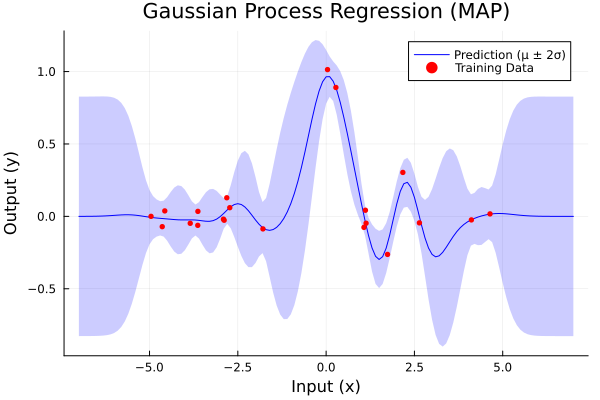

In [1]:
using LinearAlgebra
using Optim
using Zygote
using Distributions
using Plots

mutable struct GPR{T<:Real}
    X::Matrix{T}
    y::Vector{T}
    log_σf²::T
    log_ℓ::Vector{T}
    log_σn²::T
    α::Vector{T}       # (K + σn²·I)\y ; filled by `fit!`
    L::Matrix{T}       # Cholesky factor of K + σn²·I ; filled by `fit!`

    function GPR(
        X::AbstractMatrix{T},
        y::AbstractVector{T};
        σf²::T = one(T),
        ℓ::Union{T,AbstractVector{T}} = one(T),
        σn²::T = T(1e-4),
    ) where {T<:Real}

        Xₘ = Matrix{T}(X)
        yᵥ = Vector{T}(y)
        d = size(Xₘ, 2)
        ℓ_vec = typeof(ℓ) <: Real ? fill(T(ℓ), d) : collect(T.(ℓ))

        return new{T}(Xₘ, yᵥ, log(σf²), log.(ℓ_vec), log(σn²), Vector{T}(), zeros(T, 0, 0))
    end
end


@inline function se_kernel(
    X₁::AbstractMatrix{T},
    X₂::AbstractMatrix{T},
    log_σf²::T,
    log_ℓ::AbstractVector{T},
) where {T}
    σf² = exp(log_σf²)
    ℓ = exp.(log_ℓ)
    d = size(X₁, 2)

    # ★★★ 修正点: ジェネレータ式とsumを使い、非破壊的な方法で二乗距離の和を計算する ★★★
    sq_dist = sum((((X₁[:, i] .- X₂[:, i]') ./ ℓ[i]) .^ 2) for i = 1:d)

    return σf² .* exp.(-0.5 .* sq_dist)
end

const _prior_σf² = Normal(0.0, 1.0)          # log σf²
const _prior_ℓ = Normal(sqrt(2.0), sqrt(3.0))  # log ℓ
const _prior_σn² = Normal(-4.0, 1.0)         # log σn²

@inline function log_prior(θ::AbstractVector)
    d = length(θ) - 2
    log_σf², log_ℓ, log_σn² = θ[1], θ[2:(d+1)], θ[d+2]
    lp = logpdf(_prior_σf², log_σf²)
    lp += sum(logpdf.(_prior_ℓ, log_ℓ))
    lp += logpdf(_prior_σn², log_σn²)
    return lp
end


function _nll(θ::AbstractVector, X::AbstractMatrix, y::AbstractVector)
    n, d = size(X)
    log_σf², log_ℓ, log_σn² = θ[1], θ[2:(d+1)], θ[d+2]

    K = se_kernel(X, X, log_σf², log_ℓ)
    Ky = K + (exp(log_σn²) + 1e-6) * I

    # Abort (return Inf) if Ky is not positive‑definite.
    isposdef(Ky) || return Inf

    L = cholesky(Ky).L
    α = L' \ (L \ y)

    return 0.5 * (dot(y, α) + 2sum(log, diag(L)) + n * log(2π))
end

@inline function _neg_log_posterior(θ, X, y)
    nll = _nll(θ, X, y)
    isfinite(nll) || return nll                # propagate Inf
    return nll - log_prior(θ)
end


function fit!(gp::GPR; optimiser = LBFGS())
    θ₀ = [gp.log_σf²; gp.log_ℓ; gp.log_σn²]
    loss(θ) = _neg_log_posterior(θ, gp.X, gp.y)
    ∇loss!(g, θ) = (g .= Zygote.gradient(loss, θ)[1])

    println("Starting MAP optimisation …")
    res = optimize(loss, ∇loss!, θ₀, optimiser, Optim.Options(g_tol = 1e-6))
    println("Finished.  Negative log‑posterior: ", Optim.minimum(res))

    θ̂ = Optim.minimizer(res)
    d = size(gp.X, 2)
    gp.log_σf², gp.log_ℓ, gp.log_σn² = θ̂[1], θ̂[2:(d+1)], θ̂[d+2]

    # Cache reusable terms for fast predictions
    K = se_kernel(gp.X, gp.X, gp.log_σf², gp.log_ℓ)
    Ky = K + (exp(gp.log_σn²) + 1e-6) * I
    gp.L = cholesky(Ky).L
    gp.α = gp.L' \ (gp.L \ gp.y)

    return gp
end

function predict(gp::GPR, X★::AbstractMatrix)
    k★ = se_kernel(gp.X, X★, gp.log_σf², gp.log_ℓ)     # (n × m)
    μ = k★' * gp.α                                    # (m,)
    v = gp.L \ k★                                    # (n × m)
    k★★ = diag(se_kernel(X★, X★, gp.log_σf², gp.log_ℓ)) # (m,)
    var = k★★ .- vec(sum(v .^ 2, dims = 1))
    var = max.(var, eps(eltype(var)))                  # numerical safety
    return vec(μ), sqrt.(var)
end


# ------------------------------------------------------------------
# サンプル実行（修正版）
# ------------------------------------------------------------------
println("Generating sample data...")

n_samples = 21
X_train_vec = sort(-5 .+ 10 .* rand(n_samples))
X_train = reshape(X_train_vec, n_samples, 1)

y_train = vec(sinc.(X_train) .+ 0.1 .* randn(n_samples))

# キーワード引数の名前を修正済み
gpr = GPR(X_train, y_train, σf² = 1.0, ℓ = 1.0, σn² = 0.5)

fit!(gpr)

println("\nOptimized hyperparameters (MAP):")
println("  - Signal variance (σf²): ", exp(gpr.log_σf²))
println("  - Length scale (ℓ): ", exp.(gpr.log_ℓ))
println("  - Noise variance (σn²): ", exp(gpr.log_σn²))

# テストデータも N x D (141x1) の行列に変換
X_test = reshape(-7:0.1:7, :, 1)

# predict関数を呼び出す
μ, σ = predict(gpr, X_test)

println("Plotting results...")
p = plot(
    vec(X_test),
    μ,
    ribbon = 2*σ,
    fillalpha = 0.2,
    label = "Prediction (μ ± 2σ)",
    color = :blue,
)
scatter!(
    p,
    vec(X_train),
    y_train,
    label = "Training Data",
    color = :red,
    markersize = 3,
    markerstrokewidth = 0,
)
plot!(
    p,
    title = "Gaussian Process Regression (MAP)",
    xlabel = "Input (x)",
    ylabel = "Output (y)",
)

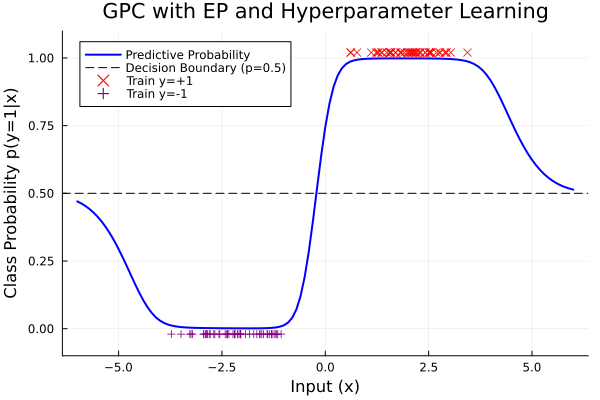

In [ ]:
using LinearAlgebra
using Optim
using Zygote
using Plots
using Distributions
using Random

# ------------------------------------------------------------------
# ガウス過程分類器の構造体
# ------------------------------------------------------------------
mutable struct GPC
    X::Matrix{Float64}
    y::Vector{Float64}
    log_σf²::Float64
    log_ℓ::Vector{Float64}
    μ::Vector{Float64}
    Σ::Matrix{Float64}
    τ̃::Vector{Float64}
    ν̃::Vector{Float64}

    function GPC(X, y; σf²=1.0, ℓ=1.0)
        n, d = size(X)
        log_σf² = log(σf²)
        log_ℓ = typeof(ℓ) <: Real ? fill(log(ℓ), d) : log.(ℓ)
        new(X, y, log_σf², log_ℓ, zeros(n), zeros(n, n), zeros(n), zeros(n))
    end
end

# ------------------------------------------------------------------
# 共分散関数（カーネル）
# ------------------------------------------------------------------
function se_kernel(X₁::AbstractMatrix, X₂::AbstractMatrix, log_σf²::Float64, log_ℓ::Vector{Float64})
    σf² = exp(log_σf²)
    ℓ = exp.(log_ℓ)
    d = size(X₁, 2)
    sq_dist = sum( ((X₁[:, i] .- X₂[:, i]') ./ ℓ[i]).^2 for i in 1:d )
    return σf² .* exp.(-0.5 .* sq_dist)
end

# ------------------------------------------------------------------
# EPアルゴリズムの実行 (内部ヘルパー関数)
# ------------------------------------------------------------------
function _run_ep!(model::GPC, K::Matrix; max_iter=50, tol=1e-4, damping=0.9)
    n = size(model.X, 1)
    model.τ̃ .= 0.0
    model.ν̃ .= 0.0
    model.Σ = copy(K)
    model.μ = zeros(n)

    for iter in 1:max_iter
        prev_μ = copy(model.μ)
        for i in 1:n |> shuffle
            τᵢ = 1.0 / model.Σ[i, i]
            νᵢ = model.μ[i] * τᵢ
            τ₋ᵢ = τᵢ - model.τ̃[i]
            if τ₋ᵢ < 1e-8; continue; end
            ν₋ᵢ = νᵢ - model.ν̃[i]
            μ₋ᵢ = ν₋ᵢ / τ₋ᵢ
            σ²₋ᵢ = 1.0 / τ₋ᵢ
            zᵢ = model.y[i] * μ₋ᵢ / sqrt(1.0 + σ²₋ᵢ)
            Φ = cdf(Normal(), zᵢ)
            if Φ < 1e-9; continue; end
            N_pdf = pdf(Normal(), zᵢ)
            μ̂ᵢ = μ₋ᵢ + model.y[i] * σ²₋ᵢ * N_pdf / (Φ * sqrt(1.0 + σ²₋ᵢ))
            σ̂²ᵢ = σ²₋ᵢ - (σ²₋ᵢ^2 * N_pdf / ((1.0 + σ²₋ᵢ) * Φ)) * (zᵢ + N_pdf / Φ)
            Δτ = 1.0/max(σ̂²ᵢ, 1e-8) - τ₋ᵢ
            Δν = μ̂ᵢ/max(σ̂²ᵢ, 1e-8) - ν₋ᵢ
            new_τ̃ᵢ = (1-damping) * model.τ̃[i] + damping * (model.τ̃[i] + Δτ)
            new_ν̃ᵢ = (1-damping) * model.ν̃[i] + damping * (model.ν̃[i] + Δν)
            Δτ_damped = new_τ̃ᵢ - model.τ̃[i]
            model.τ̃[i] = new_τ̃ᵢ
            model.ν̃[i] = new_ν̃ᵢ
            sᵢ = model.Σ[:, i]
            denom = 1.0 + Δτ_damped * model.Σ[i, i]
            if abs(denom) < 1e-8; continue; end
            model.Σ -= (sᵢ * sᵢ' * Δτ_damped) ./ denom
            model.μ = model.Σ * model.ν̃
        end

        # モニタリング
        println("Iteration $iter: max Δμ = ", norm(model.μ - prev_μ) / max(norm(prev_μ), 1e-8))

        if norm(model.μ - prev_μ) / max(norm(prev_μ), 1e-8) < tol
            return true
        end
    end
    return false
end

# ------------------------------------------------------------------
# 近似対数周辺尤度 (目的関数)
# ------------------------------------------------------------------
function negative_log_approx_marginal_likelihood(θ::Vector, X::Matrix, y::Vector)
    log_σf² = θ[1]
    log_ℓ = θ[2:end]
    K = se_kernel(X, X, log_σf², log_ℓ)
    temp_model = GPC(X, y, σf²=exp(log_σf²), ℓ=exp.(log_ℓ))
    if !_run_ep!(temp_model, K, max_iter=20)
        return 1e10
    end
    τ̃_safe = max.(temp_model.τ̃, 1e-8)
    Σ̃ = Diagonal(1.0 ./ τ̃_safe)
    μ̃ = temp_model.ν̃ ./ τ̃_safe
    Ky = K + Σ̃
    if !isposdef(Ky); return 1e10; end
    L_Ky = cholesky(Symmetric(Ky)).L
    log_Z_EP = -0.5 * logdet(L_Ky) * 2 - 0.5 * dot(μ̃, Ky \ μ̃)
    return -log_Z_EP
end

# ------------------------------------------------------------------
# モデルの学習 (ハイパーパラメータ最適化)
# ------------------------------------------------------------------
function fit!(model::GPC; optimiser_alg = LBFGS())
    d = size(model.X, 2)
    θ₀ = [model.log_σf²; model.log_ℓ]
    loss = θ -> negative_log_approx_marginal_likelihood(θ, model.X, model.y)

    println("Starting hyperparameter optimization for GPC with $(string(typeof(optimiser_alg)))...")
    
    # 解析的勾配の実装は複雑なため、Zygoteは一旦コメントアウト
    # 勾配なしのNelderMeadを推奨
    # ∇loss! = ... 
    results = optimize(loss, θ₀, optimiser_alg, Optim.Options(iterations=100, show_trace=true))
    
    θ_opt = Optim.minimizer(results)
    println("Optimization finished.")
    
    model.log_σf² = θ_opt[1]
    model.log_ℓ = θ_opt[2:end]
    
    println("\nOptimized hyperparameters:")
    println("  - Signal variance (σf²): ", exp(model.log_σf²))
    println("  - Length scale (ℓ): ", exp.(model.log_ℓ))
    
    println("Running final EP with optimized hyperparameters...")
    K = se_kernel(model.X, model.X, model.log_σf², model.log_ℓ)
    if !_run_ep!(model, K)
        @warn "Final EP run did not converge."
    end
    
    return model
end

# ------------------------------------------------------------------
# 予測 
# ------------------------------------------------------------------
function predict(model::GPC, X★::AbstractMatrix)
    K = se_kernel(model.X, model.X, model.log_σf², model.log_ℓ)
    τ̃_safe = max.(model.τ̃, 1e-8)
    S̃_sqrt = Diagonal(sqrt.(τ̃_safe))

    B = I + S̃_sqrt * K * S̃_sqrt
    L_B = cholesky(Symmetric(B)).L

    k★ = se_kernel(model.X, X★, model.log_σf², model.log_ℓ)
    a = model.ν̃
    b = L_B' \ (L_B \ (S̃_sqrt * K * a))
    μ_f★ = k★' * (a - S̃_sqrt * b)

    v = L_B \ (S̃_sqrt * k★)
    k★★ = diag(se_kernel(X★, X★, model.log_σf², model.log_ℓ))
    var_f★ = k★★ - vec(sum(v.^2, dims=1))
    var_f★ = max.(var_f★, 1e-8)

    π★ = cdf.(Normal(), vec(μ_f★) ./ sqrt.(1.0 .+ vec(var_f★)))
    return π★
end

# ------------------------------------------------------------------
# サンプル実行 
# ------------------------------------------------------------------
println("Generating sample classification data...")
n_per_class = 50
X1 = rand(Normal(-2.0, 0.7), n_per_class, 1)
X2 = rand(Normal(2.0, 0.7), n_per_class, 1)
X_train = [X1; X2]
y_train = [fill(-1.0, n_per_class); fill(1.0, n_per_class)]

gpc = GPC(X_train, y_train, σf²=1.0, ℓ=1.0)

# 勾配なしのNelderMeadで実行
fit!(gpc, optimiser_alg = NelderMead())

xx = -6:0.1:6
X_test = reshape(xx, :, 1)
π★ = predict(gpc, X_test)

p = plot(title="GPC with EP and Hyperparameter Learning", xlabel="Input (x)", ylabel="Class Probability p(y=1|x)")
contourf!(p, xx, 0:0.1:1, (x,y) -> y, levels=π★, color=:viridis, alpha=0.5, colorbar=false)
plot!(p, xx, π★, lw=2, color=:blue, label="Predictive Probability")
hline!(p, [0.5], ls=:dash, color=:black, label="Decision Boundary (p=0.5)")
scatter!(p, X_train[y_train .== 1], fill(1.02, sum(y_train.==1)), color=:red, marker=:xcross, label="Train y=+1")
scatter!(p, X_train[y_train .== -1], fill(-0.02, sum(y_train.==-1)), color=:purple, marker=:cross, label="Train y=-1")
ylims!(-0.1, 1.1)

p

In [2]:
# ------------------------------------------------------------------
# --- Sample Execution (2D Non-linear "Two Moons" Dataset) ---
# ------------------------------------------------------------------

# 2次元の "Two Moons" データセットを生成するヘルパー関数
function generate_moons_data(n_per_class::Int, noise::Float64)
    # 上側の月
    t1 = range(0, π, length=n_per_class)
    X1 = hcat(cos.(t1), sin.(t1)) .+ noise .* randn(n_per_class, 2)
    y1 = fill(1.0, n_per_class)

    # 下側の月
    t2 = range(0, π, length=n_per_class)
    X2 = hcat(1 .- cos.(t2), 0.5 .- sin.(t2)) .+ noise .* randn(n_per_class, 2)
    y2 = fill(-1.0, n_per_class)

    # データを結合
    X = [X1; X2]
    y = [y1; y2]
    
    return X, y
end


println("Generating 2D 'Two Moons' sample data...")
X_train, y_train = generate_moons_data(100, 0.1)

# モデルを初期化。入力が2次元なので、長さスケールℓも2次元で初期化
gpc = GPC(X_train, y_train, σf²=1.0, ℓ=[1.0, 1.0])

# ハイパーパラメータ学習とEPの実行
# 勾配なしのNelderMeadは比較的安定して動作します
fit!(gpc, optimiser_alg = NelderMead())

# ---- 2次元の可視化 ----
println("Plotting 2D results...")

# 予測用の2次元グリッドを作成
x_range = -1.5:0.1:2.5
y_range = -1.0:0.1:1.5
grid_x = [x for x in x_range for y in y_range]
grid_y = [y for x in x_range for y in y_range]
X_test = hcat(grid_x, grid_y)

# グリッド上の各点で予測確率を計算
π★ = predict(gpc, X_test)
# 予測結果をグリッドの形状に変換
Z = reshape(π★, length(y_range), length(x_range))

# 1. 予測確率の等高線塗りつぶし
contourf(
    x_range,                  # x 座標
    y_range,                  # y 座標
    Z;                        # 予測確率 (行: y, 列: x)
    c = :RdBu,                # カラーマップ（赤⇔青）
    clims = (0, 1),           # カラースケールを 0–1 に固定
    xlabel = "x₁",
    ylabel = "x₂",
    title = "Gaussian Process Classification on Two Moons",
    legend = false,
    size = (650, 550)         # キャンバスサイズ
)

# 2. 決定境界 (π = 0.5) を太線で重ねる
contour!(
    x_range, y_range, Z;
    levels = [0.5],           # π=0.5 だけ描画
    linewidth = 2,
    color = :black
)

# 3. 学習データをクラスごとにプロット
idx_pos = findall(y_train .==  1.0)  # 正例 (+1)
idx_neg = findall(y_train .== -1.0)  # 負例 (–1)

scatter!(
    X_train[idx_pos, 1], X_train[idx_pos, 2];
    marker = (:circle, 6, :white, stroke(0.8, :black)),
    label = "+1"
)

scatter!(
    X_train[idx_neg, 1], X_train[idx_neg, 2];
    marker = (:circle, 6, :black),
    label = "−1"
)

Generating 2D 'Two Moons' sample data...


UndefVarError: UndefVarError: `GPC` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [30]:
Z

26×41 Matrix{Float64}:
 0.935298  0.917438  0.885346  0.831328  …  5.0956e-5    0.000164434
 0.958818  0.944546  0.917014  0.866848     2.04733e-5   7.03453e-5
 0.975957  0.96556   0.943719  0.899878     8.82469e-6   3.13105e-5
 0.987239  0.980417  0.964588  0.928931     4.21803e-6   1.49064e-5
 0.993877  0.989883  0.979512  0.952824     2.3004e-6    7.78843e-6
 0.997342  0.995266  0.989172  0.970975  …  1.46158e-6   4.56277e-6
 0.998947  0.997987  0.994785  0.983571     1.09366e-6   3.0428e-6
 0.999613  0.999214  0.997704  0.991484     9.63864e-7   2.32757e-6
 0.999864  0.999712  0.999067  0.995962     9.9074e-7    2.04247e-6
 0.999953  0.999899  0.999645  0.998243     1.16739e-6   2.04304e-6
 ⋮                                       ⋱               ⋮
 1.0       1.0       1.0       0.999999     7.17217e-5   6.23196e-5
 1.0       1.0       1.0       1.0          0.000147769  0.000128265
 1.0       1.0       1.0       1.0          0.000311255  0.000272144
 0.999999  1.0       1.0       1

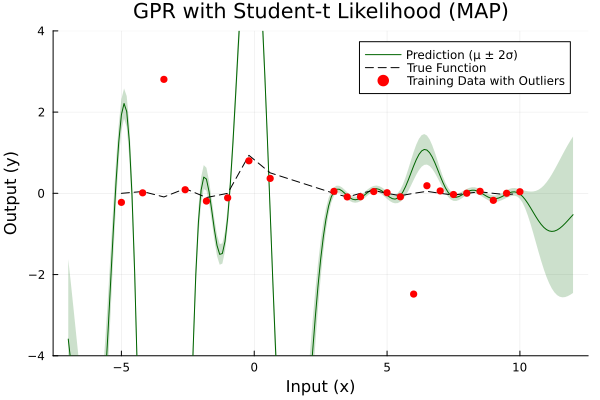

In [40]:
using LinearAlgebra
using Optim
using Plots
using Distributions
using Random
using QuadGK

# ------------------------------------------------------------------
# Student-t GPR の構造体 (変更なし)
# ------------------------------------------------------------------
mutable struct GPRT_EP
    X::Matrix{Float64}
    y::Vector{Float64}
    log_σf²::Float64
    log_ℓ::Vector{Float64}
    log_ν::Float64
    log_σ::Float64
    μ::Vector{Float64}
    Σ::Matrix{Float64}
    τ̃::Vector{Float64}
    ν̃::Vector{Float64}

    function GPRT_EP(X, y; σf²=1.0, ℓ=1.0, ν=4.0, σ=0.1)
        n, d = size(X)
        log_σf² = log(σf²)
        log_ℓ = typeof(ℓ) <: Real ? fill(log(ℓ), d) : log.(ℓ)
        log_ν = log(ν)
        log_σ = log(σ)
        new(X, y, log_σf², log_ℓ, log_ν, log_σ, zeros(n), zeros(n, n), zeros(n), zeros(n))
    end
end

# ------------------------------------------------------------------
# 共分散関数（変更なし）
# ------------------------------------------------------------------
function se_kernel(X₁::AbstractMatrix, X₂::AbstractMatrix, log_σf²::Float64, log_ℓ::Vector{Float64})
    σf² = exp(log_σf²)
    ℓ = exp.(log_ℓ)
    d = size(X₁, 2)
    sq_dist = sum( ((X₁[:, i] .- X₂[:, i]') ./ ℓ[i]).^2 for i in 1:d )
    return σf² .* exp.(-0.5 .* sq_dist)
end

# ------------------------------------------------------------------
# モーメント計算 (変更なし)
# ------------------------------------------------------------------
function calculate_moments_student_t(μ₋ᵢ, σ²₋ᵢ, yᵢ, ν, σ)
    integrand(f) = pdf(Normal(μ₋ᵢ, sqrt(σ²₋ᵢ)), f) * pdf(LocationScale(f, σ, TDist(ν)), yᵢ)
    Ẑᵢ, _ = quadgk(integrand, -Inf, Inf, rtol=1e-5)
    if Ẑᵢ < 1e-10; return (Inf, Inf, Inf); end
    integral_μ, _ = quadgk(f -> f * integrand(f), -Inf, Inf, rtol=1e-5)
    μ̂ᵢ = integral_μ / Ẑᵢ
    integral_var, _ = quadgk(f -> (f - μ̂ᵢ)^2 * integrand(f), -Inf, Inf, rtol=1e-5)
    σ̂²ᵢ = integral_var / Ẑᵢ
    return Ẑᵢ, μ̂ᵢ, σ̂²ᵢ
end

# ------------------------------------------------------------------
# EPアルゴリズムの実行 (変更なし)
# ------------------------------------------------------------------
function _run_ep!(model::GPRT_EP, K::Matrix; max_iter=50, tol=1e-5, damping=0.8)
    n = size(model.X, 1)
    ν = exp(model.log_ν)
    σ = exp(model.log_σ)
    model.τ̃ .= 0.0
    model.ν̃ .= 0.0
    model.Σ = copy(K)
    model.μ = zeros(n)
    for iter in 1:max_iter
        prev_μ = copy(model.μ)
        for i in 1:n |> shuffle
            τᵢ = 1.0 / model.Σ[i, i]

            println("Σ for i=$i: ", model.Σ[i, i])

            νᵢ = model.μ[i] * τᵢ
            τ₋ᵢ = τᵢ - model.τ̃[i]
            if τ₋ᵢ < 1e-8; continue; end
            ν₋ᵢ = νᵢ - model.ν̃[i]
            μ₋ᵢ = ν₋ᵢ / τ₋ᵢ
            σ²₋ᵢ = 1.0 / τ₋ᵢ
            _, μ̂ᵢ, σ̂²ᵢ = calculate_moments_student_t(μ₋ᵢ, σ²₋ᵢ, model.y[i], ν, σ)
            if isinf(μ̂ᵢ) || σ̂²ᵢ <= 0; continue; end
            Δτ = 1.0/σ̂²ᵢ - τ₋ᵢ
            Δν = μ̂ᵢ/σ̂²ᵢ - ν₋ᵢ
            new_τ̃ᵢ = (1-damping) * model.τ̃[i] + damping * (model.τ̃[i] + Δτ)
            new_ν̃ᵢ = (1-damping) * model.ν̃[i] + damping * (model.ν̃[i] + Δν)
            Δτ_damped = new_τ̃ᵢ - model.τ̃[i]
            model.τ̃[i] = new_τ̃ᵢ
            model.ν̃[i] = new_ν̃ᵢ
            sᵢ = model.Σ[:, i]
            denom = 1.0 + Δτ_damped * model.Σ[i, i]
            if abs(denom) < 1e-8; continue; end
            model.Σ -= (sᵢ * sᵢ' * Δτ_damped) ./ denom
            model.μ = model.Σ * model.ν̃
        end

        # # モニタリング
        # println("Iteration $iter: max Δμ = ", norm(model.μ - prev_μ) / max(norm(prev_μ), 1e-8))

        if norm(model.μ - prev_μ) / max(norm(prev_μ), 1e-8) < tol
            return true
        end
    end
    @warn "EP did not converge in $max_iter iterations."
    return false
end

# ------------------------------------------------------------------
# 対数事前分布 log p(θ) - ★★★ 新規追加 ★★★
# ------------------------------------------------------------------
function log_prior(θ::Vector)
    d = length(θ) - 3
    log_σf², log_ℓ, log_ν, log_σ = θ[1], θ[2:d+1], θ[d+2], θ[d+3]

    # 各ハイパーパラメータの対数値に対する事前分布
    prior_σf² = Normal(0.0, 1.0)
    prior_ℓ   = Normal(log(1.0), 1.0) # 長さスケールの事前知識に応じて調整
    prior_ν   = Normal(log(4.0), 1.0) # 自由度νが4あたりになるように
    prior_σ   = Normal(log(0.1), 1.0) # ノイズスケールσが0.1あたりになるように

    lp = logpdf(prior_σf², log_σf²)
    lp += sum(logpdf.(prior_ℓ, log_ℓ))
    lp += logpdf(prior_ν, log_ν)
    lp += logpdf(prior_σ, log_σ)
    
    return lp
end

# ------------------------------------------------------------------
# 近似対数周辺尤度 (内部ヘルパー関数)
# ------------------------------------------------------------------
function _negative_log_approx_marginal_likelihood(θ::Vector, X::Matrix, y::Vector)
    d = size(X, 2)
    log_σf², log_ℓ, log_ν, log_σ = θ[1], θ[2:d+1], θ[d+2], θ[d+3]

    K = se_kernel(X, X, log_σf², log_ℓ)
    temp_model = GPRT_EP(X, y, σf²=exp(log_σf²), ℓ=exp.(log_ℓ), ν=exp(log_ν), σ=exp(log_σ))
    
    if !_run_ep!(temp_model, K, max_iter=10000)
        return 1e10
    end
    
    τ̃_safe = max.(temp_model.τ̃, 1e-8)
    Σ̃ = Diagonal(1.0 ./ τ̃_safe)
    μ̃ = temp_model.ν̃ ./ τ̃_safe
    Ky = K + Σ̃
    if !isposdef(Ky); return 1e10; end
    L_Ky = cholesky(Symmetric(Ky)).L
    
    log_Z_EP = -0.5 * logdet(L_Ky) * 2 - 0.5 * dot(μ̃, Ky \ μ̃)
    
    return -log_Z_EP
end

# ------------------------------------------------------------------
# 負の対数事後確率 (新しい目的関数) - ★★★ 新規追加 ★★★
# ------------------------------------------------------------------
function negative_log_posterior(θ::Vector, X::Matrix, y::Vector)
    # -log p(D|θ)
    nll = _negative_log_approx_marginal_likelihood(θ, X, y)
    if isinf(nll) || nll > 1e9
        return nll
    end
    
    # log p(θ)
    lp = log_prior(θ)
    
    # 最小化対象: -log p(D|θ) - log p(θ)
    return nll - lp
end


# ------------------------------------------------------------------
# モデルの学習 (MAP推定) - ★★★ 修正箇所 ★★★
# ------------------------------------------------------------------
function fit!(model::GPRT_EP; optimiser_alg = NelderMead(), options=Optim.Options(iterations=50))
    d = size(model.X, 2)
    θ₀ = [model.log_σf², model.log_ℓ..., model.log_ν, model.log_σ]
    
    # 目的関数を対数事後確率に変更
    loss(θ) = negative_log_posterior(θ, model.X, model.y)

    println("Starting MAP hyperparameter optimization for GPR with Student-t likelihood...")
    results = optimize(loss, θ₀, optimiser_alg, options)
    
    θ_opt = Optim.minimizer(results)
    println("Optimization finished.")
    
    model.log_σf² = θ_opt[1]
    model.log_ℓ = θ_opt[2:d+1]
    model.log_ν = θ_opt[d+2]
    model.log_σ = θ_opt[d+3]
    
    println("\nOptimized hyperparameters (MAP):")
    println("  - Signal variance (σf²): ", exp(model.log_σf²))
    println("  - Length scale (ℓ): ", exp.(model.log_ℓ))
    println("  - Degrees of Freedom (ν): ", exp(model.log_ν))
    println("  - Noise scale (σ): ", exp(model.log_σ))
    
    println("Running final EP with optimized hyperparameters...")
    K = se_kernel(model.X, model.X, model.log_σf², model.log_ℓ)
    if !_run_ep!(model, K)
        @warn "Final EP run did not converge."
    end
    
    return model
end

# ------------------------------------------------------------------
# 予測 (変更なし)
# ------------------------------------------------------------------
function predict(model::GPRT_EP, X★::AbstractMatrix)
    K = se_kernel(model.X, model.X, model.log_σf², model.log_ℓ)
    k★ = se_kernel(model.X, X★, model.log_σf², model.log_ℓ)
    k★★ = diag(se_kernel(X★, X★, model.log_σf², model.log_ℓ))
    K_inv = inv(Symmetric(K))
    μ★ = k★' * K_inv * model.μ
    var★ = k★★ - diag(k★' * (K_inv - K_inv * model.Σ * K_inv) * k★)
    var★ = max.(var★, 1e-8)
    return vec(μ★), sqrt.(var★)
end

# ------------------------------------------------------------------
# サンプル実行
# ------------------------------------------------------------------
println("Generating sample data with outliers...")
X_train_vec = sort(vcat(-5:0.8:1, 3:0.5:10))
X_train = reshape(X_train_vec, :, 1)
y_true = vec(sinc.(X_train))
y_train = y_true .+ 0.1 .* randn(length(y_true))
y_train[3] += 3.0
y_train[15] -= 2.5
println("Outliers added at indices 3 and 15.")

gprt = GPRT_EP(X_train, y_train, σf²=1.0, ℓ=1.0, ν=4.0, σ=0.3)
fit!(gprt, options=Optim.Options(iterations=1000, show_trace=true))

X_test = reshape(-7:0.1:12, :, 1)
μ, σ = predict(gprt, X_test)

p = plot(vec(X_test), μ, ribbon=2*σ, fillalpha=0.2, label="Prediction (μ ± 2σ)", color=:darkgreen)
plot!(p, vec(X_train), y_true, ls=:dash, color=:black, label="True Function")
scatter!(p, vec(X_train), y_train, label="Training Data with Outliers", color=:red, markerstrokewidth=0)
plot!(p, title="GPR with Student-t Likelihood (MAP)", xlabel="Input (x)", ylabel="Output (y)")
ylims!(-4, 4)

p

Generating 2D sample data with outliers...

--- Training t-Process Classifier (v=5) ---
Running EP for t-Process Classifier...
Iteration 1: max Δμ = 3.643919270552198e9
Iteration 2: max Δμ = 0.11763073458888473
Iteration 3: max Δμ = 0.8704811674631658
Iteration 4: max Δμ = 24.457676629775925
Iteration 5: max Δμ = 0.026457050729835334
Iteration 6: max Δμ = 0.0064465310534696195
Iteration 7: max Δμ = 0.10016476973217159
Iteration 8: max Δμ = 0.017382518683608544
Iteration 9: max Δμ = 1.3807670541535633e-14

Plotting results...


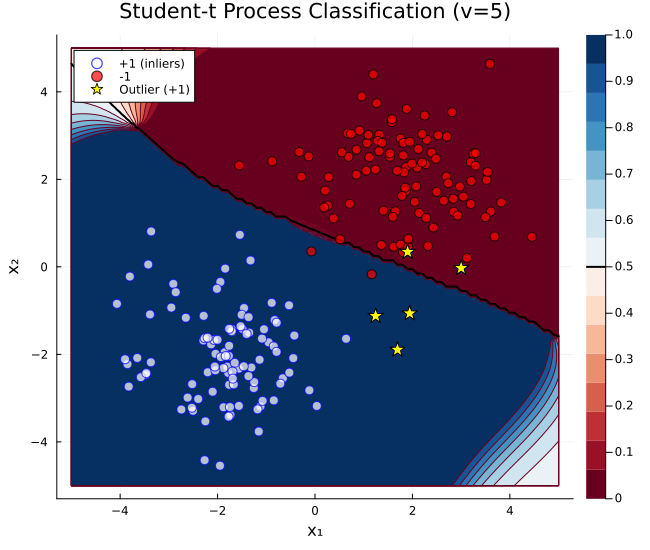

In [ ]:
using LinearAlgebra
using Optim
using Plots
using Distributions
using Random

# ------------------------------------------------------------------
# t過程分類器の構造体
# ------------------------------------------------------------------
mutable struct TPC # t-Process Classifier
    X::Matrix{Float64}
    y::Vector{Float64}
    v::Float64          # ★ t分布の自由度
    log_σf²::Float64
    log_ℓ::Vector{Float64}

    # EP法で使われるパラメータ
    μ::Vector{Float64}
    Σ::Matrix{Float64}
    τ̃::Vector{Float64}
    ν̃::Vector{Float64}

    function TPC(X, y; v=10.0, σf²=1.0, ℓ=1.0)
        n, d = size(X)
        log_σf² = log(σf²)
        log_ℓ = typeof(ℓ) <: Real ? fill(log(ℓ), d) : log.(ℓ)
        new(X, y, v, log_σf², log_ℓ, zeros(n), zeros(n, n), zeros(n), zeros(n))
    end
end

# ------------------------------------------------------------------
# 共分散関数（カーネル）
# ------------------------------------------------------------------
function se_kernel(X₁::AbstractMatrix, X₂::AbstractMatrix, log_σf²::Float64, log_ℓ::Vector{Float64})
    σf² = exp(log_σf²)
    ℓ = exp.(log_ℓ)
    d = size(X₁, 2)
    sq_dist = sum( ((X₁[:, i] .- X₂[:, i]') ./ ℓ[i]).^2 for i in 1:d )
    return σf² .* exp.(-0.5 .* sq_dist)
end

# ------------------------------------------------------------------
# EPアルゴリズムの実行 (t過程版)
# ------------------------------------------------------------------
function _run_ep!(model::TPC, K::Matrix; max_iter=50, tol=1e-4, damping=0.9, ε=1e-3)
    n = size(model.X, 1)
    # EPパラメータの初期化
    model.τ̃ .= 0.0
    model.ν̃ .= 0.0
    model.Σ = copy(K) # 事前分布は St(0, K, v) だが、共分散行列は同じK
    model.μ = zeros(n)

    # 自由度の関係式 (論文 eq. (48) 参照)
    # サイト近似は1次元なので k=1
    ṽ = model.v + n - 1

    for iter in 1:max_iter
        prev_μ = copy(model.μ)
        for i in 1:n |> shuffle
            # キャビティ分布の計算 (論文 eq. (72, 73) に基づく)
            μᵢ = model.μ[i]
            σ²ᵢ = model.Σ[i, i]

            println("Σ for i=$i: ", model.Σ[i, i])            

            # 自由度を v から ṽ に補正 (論文 Appendix E.1)
            σ_prime_sq_i = σ²ᵢ * model.v / ṽ

            τᵢ = 1.0 / σ_prime_sq_i
            νᵢ = μᵢ / σ_prime_sq_i

            τ₋ᵢ = τᵢ - model.τ̃[i]
            if τ₋ᵢ < 1e-8; continue; end
            ν₋ᵢ = νᵢ - model.ν̃[i]

            μ₋ᵢ = ν₋ᵢ / τ₋ᵢ
            σ²₋ᵢ = 1.0 / τ₋ᵢ

            # モーメントマッチング (論文 eq. (74-76) に基づく)
            # 尤度はステップ関数 p(yᵢ|fᵢ) = ε + (1-2ε)Θ(yᵢfᵢ) (論文 eq. (55))
            z = model.y[i] * μ₋ᵢ / sqrt(σ²₋ᵢ)

            dist_t_cavity = TDist(ṽ)
            cdf_t = cdf(dist_t_cavity, z)
            pdf_t = pdf(dist_t_cavity, z)

            Z₂ = ε + (1-2ε) * cdf_t
            if Z₂ < 1e-9; continue; end

            α = (1-2ε) * pdf_t / (Z₂ * sqrt(σ²₋ᵢ))

            μ̂ᵢ = μ₋ᵢ + σ²₋ᵢ * α * model.y[i]
            σ̂²ᵢ = σ²₋ᵢ * (1.0 - σ²₋ᵢ * α * (model.y[i]*z + α*σ²₋ᵢ) )

            # サイトパラメータと事後分布の更新
            σ̂²ᵢ = max(σ̂²ᵢ, 1e-8)
            Δτ = 1.0/σ̂²ᵢ - τ₋ᵢ
            Δν = μ̂ᵢ/σ̂²ᵢ - ν₋ᵢ

            new_τ̃ᵢ = (1-damping) * model.τ̃[i] + damping * (model.τ̃[i] + Δτ)
            new_ν̃ᵢ = (1-damping) * model.ν̃[i] + damping * (model.ν̃[i] + Δν)
            Δτ_damped = new_τ̃ᵢ - model.τ̃[i]

            model.τ̃[i] = new_τ̃ᵢ
            model.ν̃[i] = new_ν̃ᵢ

            # 事後分布の更新 (GPCと同様のランク1更新で近似)
            sᵢ = model.Σ[:, i]
            denom = 1.0 + Δτ_damped * σ²ᵢ
            if abs(denom) < 1e-8; continue; end
            model.Σ -= (sᵢ * sᵢ' * Δτ_damped) ./ denom
            model.μ = model.Σ * model.ν̃
        end

        # モニタリング
        println("Iteration $iter: max Δμ = ", norm(model.μ - prev_μ) / max(norm(prev_μ), 1e-8))

        if norm(model.μ - prev_μ) / max(norm(prev_μ), 1e-8) < tol
            return true
        end
    end
    return false
end


# ------------------------------------------------------------------
# モデルの学習（ハイパーパラメータは固定）
# ------------------------------------------------------------------
function fit!(model::TPC)
    println("Running EP for t-Process Classifier...")
    K = se_kernel(model.X, model.X, model.log_σf², model.log_ℓ)
    if !_run_ep!(model, K)
        @warn "EP run did not converge."
    end
    return model
end

# ------------------------------------------------------------------
# 予測
# ------------------------------------------------------------------
function predict(model::TPC, X★::AbstractMatrix)
    # 潜在変数 f* の予測分布を計算 (論文 Appendix E.3)
    k★ = se_kernel(model.X, X★, model.log_σf², model.log_ℓ)
    μ_f★ = k★' * (model.Σ \ model.μ)
    v_f★ = diag(se_kernel(X★, X★, model.log_σf², model.log_ℓ)) .- vec(sum((model.Σ \ k★) .* k★, dims=1))
    v_f★ = max.(v_f★, 1e-8)

    # 予測分布は St(μ_f★, ..., v+n) (論文 eq. (83))
    v_pred = model.v + size(model.X, 1)

    # 最終的な予測確率を計算
    dist_t_pred = TDist(v_pred)
    π★ = cdf.(dist_t_pred, vec(μ_f★) ./ sqrt.(v_f★))

    return π★
end

# ------------------------------------------------------------------
# --- Sample Execution (外れ値ありのデータセット) ---
# ------------------------------------------------------------------

# 外れ値ありの2次元データを生成するヘルパー関数
function generate_outlier_data(n_per_class::Int, noise::Float64, n_outliers::Int)
    X1 = randn(n_per_class, 2) .+ [-2.0, -2.0]'
    y1 = fill(1.0, n_per_class)
    X2 = randn(n_per_class, 2) .+ [2.0, 2.0]'
    y2 = fill(-1.0, n_per_class)
    X_out = randn(n_outliers, 2) .+ [2.0, -2.0]'
    y_out = fill(1.0, n_outliers)
    X = [X1; X2; X_out]
    y = [y1; y2; y_out]
    return X, y, X_out
end

println("Generating 2D sample data with outliers...")
X_train, y_train, X_outliers = generate_outlier_data(100, 0.5, 5)

# --- t過程分類器の実行 ---
println("\n--- Training t-Process Classifier (v=5) ---")
# ハイパーパラメータは固定値を使用
tpc = TPC(X_train, y_train, v=5.0, σf²=1.0, ℓ=[1.5, 1.5])
fit!(tpc)

# ---- 結果の可視化 ----
println("\nPlotting results...")

# 予測用のグリッドを作成
x_range = -5:0.1:5
y_range = -5:0.1:5
grid_x = [x for x in x_range for y in y_range]
grid_y = [y for x in x_range for y in y_range]
X_test = hcat(grid_x, grid_y)

# 予測確率を計算
π_tpc = predict(tpc, X_test)
Z_tpc = reshape(π_tpc, length(y_range), length(x_range))

# 予測確率の等高線塗りつぶし
p = contourf(
    x_range, y_range, Z_tpc,
    c=:RdBu, clims=(0, 1),
    xlabel="x₁", ylabel="x₂",
    title="Student-t Process Classification (v=5)",
    legend=true,
    size=(650, 550)
)

# 決定境界 (π = 0.5) を太線で重ねる
contour!(p, x_range, y_range, Z_tpc, levels=[0.5], linewidth=2, color=:black, label="")

# 学習データをプロット
idx_pos = findall(y_train .== 1.0)
idx_neg = findall(y_train .== -1.0)
scatter!(p, X_train[idx_pos, 1], X_train[idx_pos, 2], marker=(:circle, 5, 0.7, :white, stroke(1, :blue)), label="+1 (inliers)")
scatter!(p, X_train[idx_neg, 1], X_train[idx_neg, 2], marker=(:circle, 5, 0.7, :red), label="-1")
scatter!(p, X_outliers[:, 1], X_outliers[:, 2], marker=(:star5, 8, :yellow, stroke(1, :black)), label="Outlier (+1)")

# プロットを表示
p

In [25]:
y_train

205-element Vector{Float64}:
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  ⋮
 -1.0
 -1.0
 -1.0
 -1.0
  1.0
  1.0
  1.0
  1.0
  1.0